## Загрузка данных

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import random
import seaborn as sns
import torch
import torch.nn as nn

from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler



from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn


import skorch
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor

import random

In [41]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', index_col='Unnamed: 0')

## Предобработка и анализ данных

In [42]:
df

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

     Star type Star color  
0            0        Red  
1            0        Red  
2            0        Red  
3            0        Red  
4            0        Red  
..         ...        ...  
235          5       Blue  
236          5       Blue  
237          5      White  
238          5      White  
239          5       Blue  

[240 rows x 6 columns]

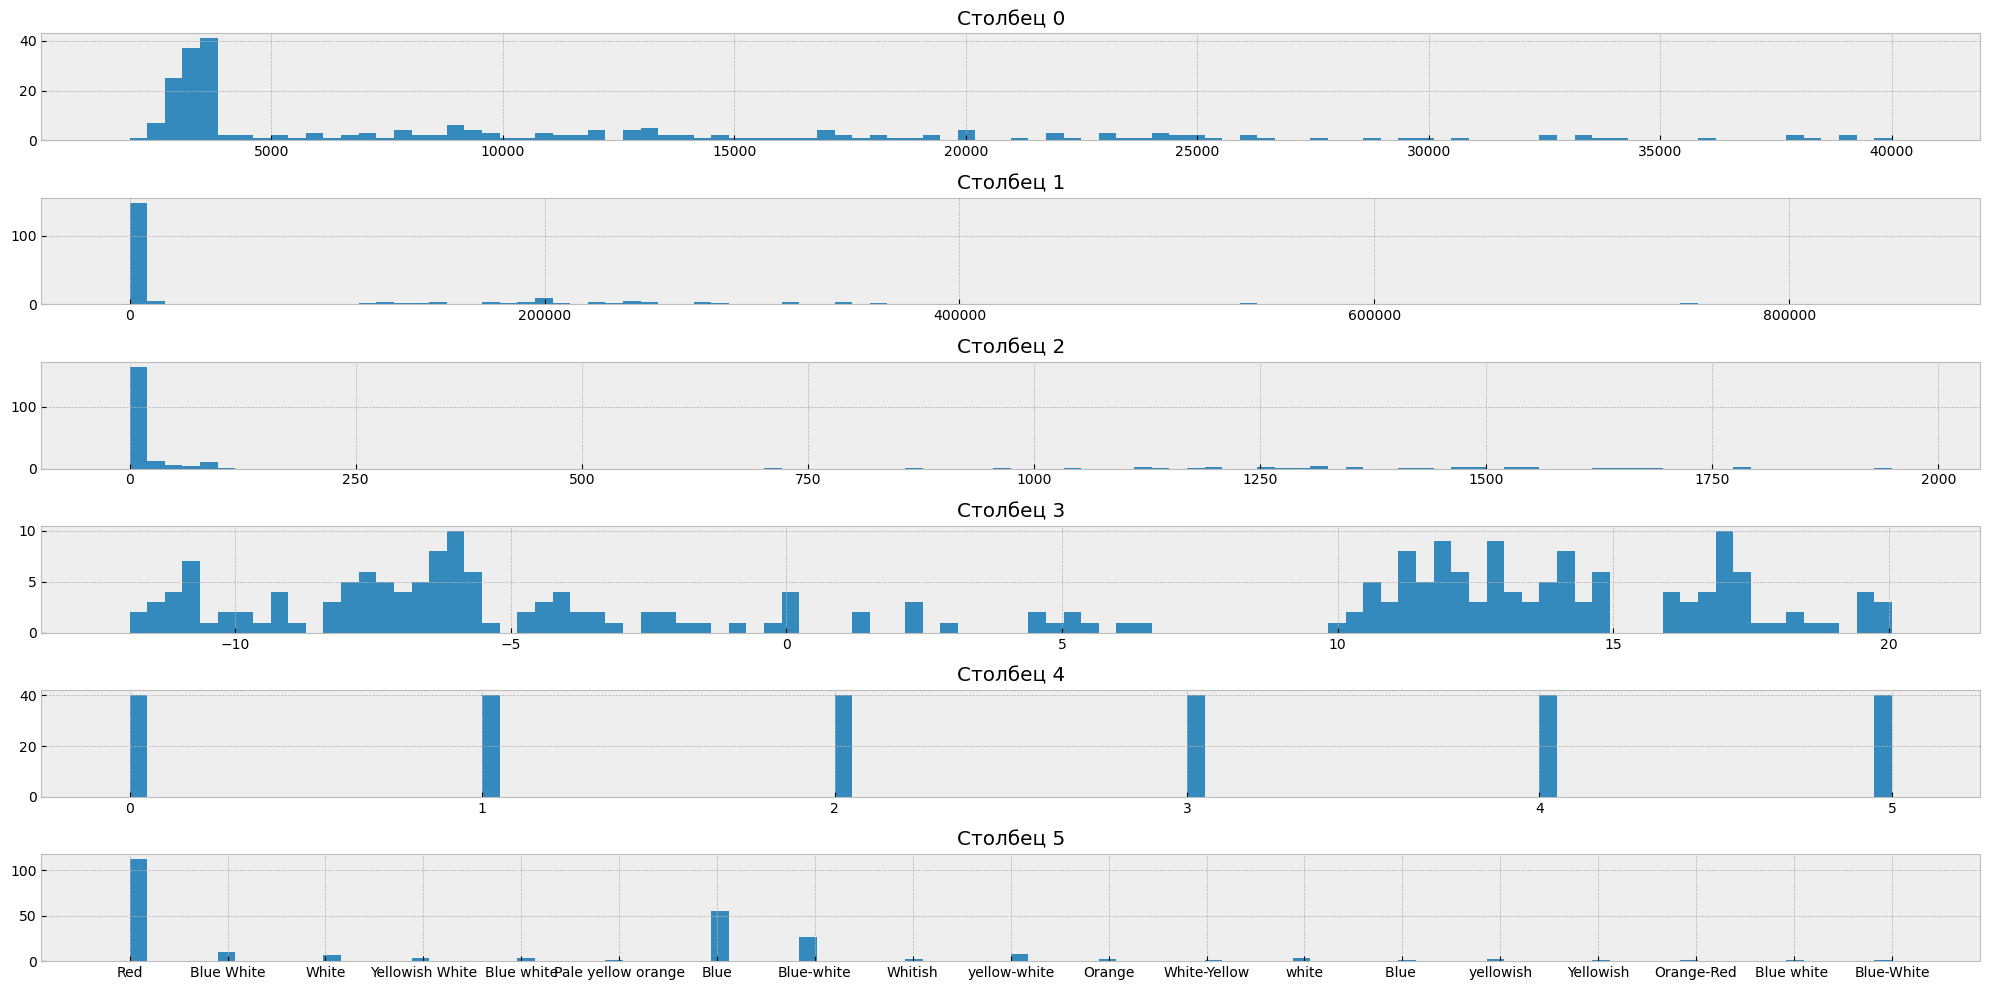

In [43]:
num_columns = df.shape[1]
num_rows = 6
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [44]:
y = df["Temperature (K)"]
X = df.drop("Temperature (K)", axis=1)

In [45]:
X['Star color'] = OrdinalEncoder().fit_transform(X[['Star color']])

In [46]:
scaler = StandardScaler()
columns_X = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns_X)

del scaler
del columns_X

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

In [48]:
X_train_tensor = torch.FloatTensor(X_train.values) 
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

In [49]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [50]:
num_epochs = 1000
learning_rate = 0.2

In [51]:
def init_weights(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 

In [52]:
results_loss_1 = [] 
results_time_1 = [] 
results_loss_2 = [] 

n_in_neurons = X_train_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [53]:
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_tensor).flatten()
     
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    with torch.no_grad():   
            net.eval()
            test_preds = net.forward(X_test_tensor).flatten()
            loss_value_test = loss(test_preds, y_test_tensor) 
            print('epoch {}, RMSE train {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value),\
                                                                           torch.Tensor.sqrt_(loss_value_test)))                
            
            results_loss_1.append(loss_value.tolist())
            results_time_1.append(epoch)
            results_loss_2.append(loss_value_test.tolist())
                
results_loss_1 = pd.Series(results_loss_1)
results_time_1 = pd.Series(results_time_1)
results_loss_2 = pd.Series(results_loss_2)

best_idx = results_loss_2.idxmin()

print('')
print('Лучшее значение RMSE test: ', results_loss_2[best_idx])
print('RMSE train: ', results_loss_1[best_idx])
print('Epoch: ', results_time_1[best_idx])

epoch 0, RMSE train 13897.8672, RMSE test 15249.1289
epoch 1, RMSE train 13894.1191, RMSE test 15244.7715
epoch 2, RMSE train 13889.3291, RMSE test 15238.3330
epoch 3, RMSE train 13882.5859, RMSE test 15228.7891
epoch 4, RMSE train 13873.2627, RMSE test 15211.4482
epoch 5, RMSE train 13858.6699, RMSE test 15188.0771
epoch 6, RMSE train 13837.4053, RMSE test 15157.8887
epoch 7, RMSE train 13810.4316, RMSE test 15118.6387
epoch 8, RMSE train 13775.9004, RMSE test 15067.3711
epoch 9, RMSE train 13731.0674, RMSE test 15002.0859
epoch 10, RMSE train 13674.3477, RMSE test 14920.2656
epoch 11, RMSE train 13603.9053, RMSE test 14819.5068
epoch 12, RMSE train 13517.5010, RMSE test 14696.8711
epoch 13, RMSE train 13412.5078, RMSE test 14549.0820
epoch 14, RMSE train 13286.3457, RMSE test 14372.5439
epoch 15, RMSE train 13136.4502, RMSE test 14164.5146
epoch 16, RMSE train 12960.3311, RMSE test 13922.6592
epoch 17, RMSE train 12755.6592, RMSE test 13645.3877
epoch 18, RMSE train 12521.1084, RMSE 

In [20]:
def build_graphic(target, preds):
    figure, axis = plt.subplots(1, 1, figsize=(32,8))
    
    plt.style.use('bmh')

    axis.bar(x = target.index, height = preds.int(), width = 3, alpha=0.5, label = 'Прогноз', color='blue')
    axis.bar(x = target.index, height = target.values, width = 1, label = 'Факт', color='orange')

    plt.xlabel("Номер звезды в таблице данных")
    plt.ylabel("Температура звезды")

    figure.suptitle('График')
    plt.legend()
    plt.show()

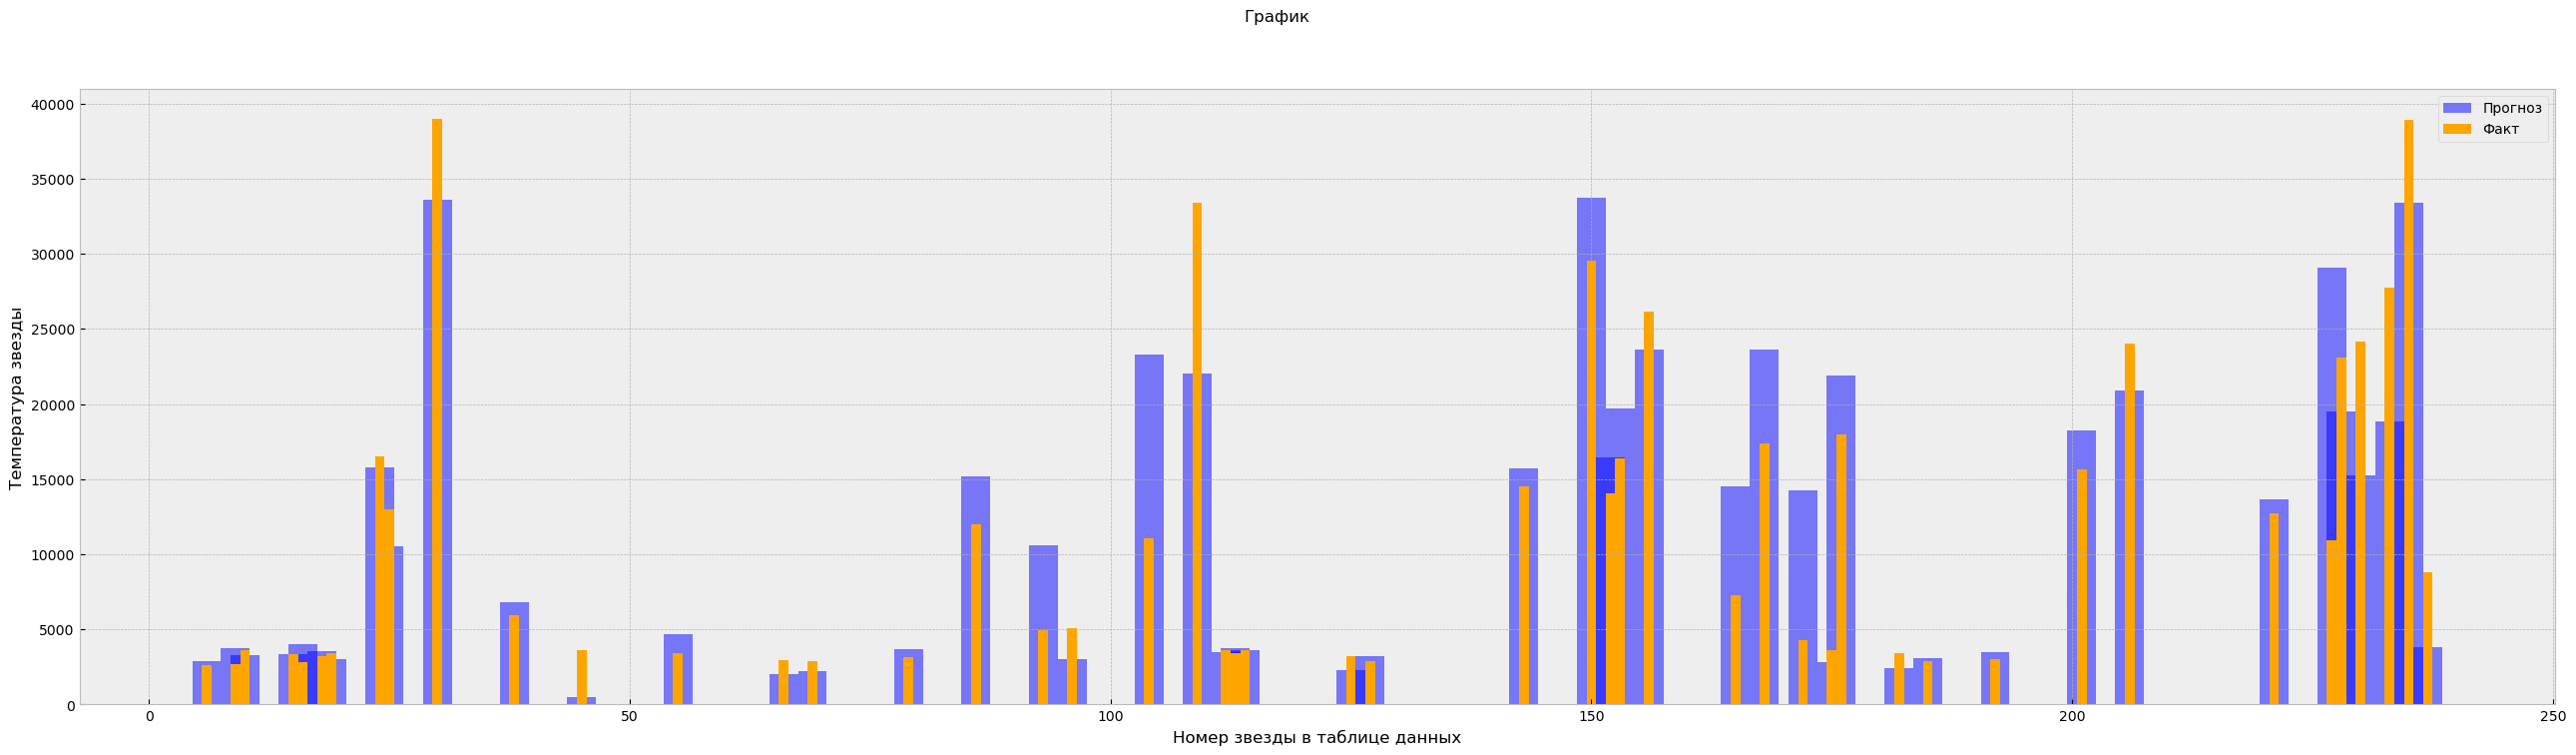

In [21]:
build_graphic(y_test, test_preds)

## Улучшение нейронной сети

In [17]:

X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(X_train_n.shape, y_train_n.shape, X_valid_n.shape, y_valid_n.shape)
X_train_n_tensor = torch.FloatTensor(X_train_n.values) 
X_valid_n_tensor = torch.FloatTensor(X_valid_n.values)
y_train_n_tensor = torch.FloatTensor(y_train_n.values)
y_valid_n_tensor = torch.FloatTensor(y_valid_n.values)

(153, 5) (153,) (39, 5) (39,)


In [18]:
results_loss_1 = [] 
results_time_1 = [] 
results_loss_2 = []
do1 = []
do2 = []

p1 = [.2, .5, .8]
p2 = p1

num_epochs = 10_000

for v1 in p1:
      for v2 in p2:
        net2 = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ELU(),
            nn.Dropout(p=v1),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ELU(),
            nn.Dropout(p=v2),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
        )

        net2.apply(init_weights)
        optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)
        loss = nn.MSELoss()
        for epoch in range(num_epochs):
            net2.train()
            optimizer.zero_grad()
            preds = net2.forward(X_train_n_tensor).flatten()
            
            loss_value = loss(preds, y_train_n_tensor)
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():   
                    net2.eval()
                    valid_preds = net2.forward(X_valid_n_tensor).flatten()
                    loss_value_valid = loss(valid_preds, y_valid_n_tensor) 
                    print('Do1 {}, Do2 {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(v1, v2, epoch, torch.Tensor.sqrt_(loss_value),\
                                                                                torch.Tensor.sqrt_(loss_value_valid)))                
                    
                    results_loss_1.append(loss_value.tolist())
                    results_time_1.append(epoch)
                    results_loss_2.append(loss_value_valid.tolist())
                    do1.append(v1)
                    do2.append(v2)

results_loss_1 = pd.Series(results_loss_1)
results_time_1 = pd.Series(results_time_1)
results_loss_2 = pd.Series(results_loss_2)
do1 = pd.Series(do1)
do2 = pd.Series(do2)

best_idx = results_loss_2.idxmin()
       
print('')
print('Лучшее значение RMSE valid: ', results_loss_2[best_idx])
print('RMSE train: ', results_loss_1[best_idx])
print('Dropout 1: ', do1[best_idx])
print('Dropout 2: ', do2[best_idx])
print('Epoch: ', results_time_1[best_idx])


Do1 0.2, Do2 0.2, epoch 0, RMSE train 14114.5947, RMSE valid 13004.7354
Do1 0.2, Do2 0.2, epoch 1, RMSE train 14110.4004, RMSE valid 12997.5850
Do1 0.2, Do2 0.2, epoch 2, RMSE train 14101.4688, RMSE valid 12984.2549
Do1 0.2, Do2 0.2, epoch 3, RMSE train 14091.6943, RMSE valid 12968.2920
Do1 0.2, Do2 0.2, epoch 4, RMSE train 14079.4678, RMSE valid 12945.7178
Do1 0.2, Do2 0.2, epoch 5, RMSE train 14056.9307, RMSE valid 12914.2490
Do1 0.2, Do2 0.2, epoch 6, RMSE train 14027.4375, RMSE valid 12872.3721
Do1 0.2, Do2 0.2, epoch 7, RMSE train 14005.5498, RMSE valid 12816.8838
Do1 0.2, Do2 0.2, epoch 8, RMSE train 13923.5420, RMSE valid 12748.5381
Do1 0.2, Do2 0.2, epoch 9, RMSE train 13899.5908, RMSE valid 12662.6719
Do1 0.2, Do2 0.2, epoch 10, RMSE train 13807.9717, RMSE valid 12556.5742
Do1 0.2, Do2 0.2, epoch 11, RMSE train 13695.7793, RMSE valid 12428.0996
Do1 0.2, Do2 0.2, epoch 12, RMSE train 13631.9395, RMSE valid 12273.8193
Do1 0.2, Do2 0.2, epoch 13, RMSE train 13426.5186, RMSE valid

In [56]:
results_loss_3 = []
results_time_3 = []
results_size_3 = []

batch_size = [8, 16, 24, 32]

net3 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_1),    
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_2),    
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

for size in batch_size:
        
        net3.apply(init_weights)
        optimizer = torch.optim.Adam(net3.parameters(), lr=learning_rate)
        loss = nn.MSELoss()
        num_batches = ceil(len(X_train_n)/size)
                
        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train_n)) 
            for batch_idx in range(num_batches):
        
                start_index = batch_idx * size 
                net3.train()                                              # новый код
                optimizer.zero_grad()
        
                batch_indexes = order[start_index:start_index+size] 
                X_batch = X_train_n_tensor[batch_indexes]
                y_batch = y_train_n_tensor[batch_indexes]
        
                preds = net3.forward(X_batch).flatten()
          
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

            if epoch % 10 == 0 or epoch == num_epochs - 1:
                
                with torch.no_grad():                                     # новый код
                
                    net3.eval()
                    test_preds = net3.forward(X_valid_n_tensor).flatten()
                    loss_value_valid = loss(test_preds, y_valid_n_tensor)
                    print('size {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(size, epoch, \
                                                        torch.Tensor.sqrt_(loss_value), torch.Tensor.sqrt_(loss_value_valid)))  
                    results_loss_3.append(loss_value_valid.tolist())
                    results_time_3.append(epoch)
                    results_size_3.append(size)

index = results_loss_3.index(min(results_loss_3))
print('')
print('Лучшее значение RMSE valid: size {}, epoch {}, RMSE {:.4f}'.format(results_size_3[index], \
                                                                              results_time_3[index], min(results_loss_3))) 


/Users/vs/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10])

## Выводы